# Analysis of the effectiveness of a subscription in a scooter rental service
This project analyzes the effectiveness of the subscription model in a scooter-sharing service. The goal is to understand user behavior with and without a subscription and evaluate how it affects trip duration and revenue.

# Data description

Users table `users_go.csv`

- `user_id` — unique user identifier.

- `name` — user name.

- `age` — age.

- `city` — city.

- `subscription_type` — subscription type: `free`, `ultra`.

Rides table `rides_go.csv`

- `user_id` — unique user identifier.

- `distance` — distance in meters that the user has traveled in the current session.

- `duration` — session duration in minutes, i.e. the time from the moment the user clicked the "Start ride" button until he clicked the "End ride" button.

- `date` — date of the ride.

Subscriptions table `subscriptions_go.csv`

- `subscription_type` — subscription type.

- `minute_price` — the price of one minute of ride for this subscription.

- `start_ride_price` — the price to start a ride.

- `subscription_fee` — the price of the monthly payment.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

We will save three CSV files into separate DataFrames. The DataFrames will be named according to the file names, with the prefix `df_` added. File links:

- https://code.s3.yandex.net/datasets/users_go.csv  
- https://code.s3.yandex.net/datasets/rides_go.csv  
- https://code.s3.yandex.net/datasets/subscriptions_go.csv

In [2]:
df_users_go = pd.read_csv('https://code.s3.yandex.net/datasets/users_go.csv')
df_rides_go = pd.read_csv('https://code.s3.yandex.net/datasets/rides_go.csv')
df_subscriptions_go = pd.read_csv('https://code.s3.yandex.net/datasets/subscriptions_go.csv')

Let's output the first five rows of each data frame. Let's get acquainted with the contents of the tables.

In [3]:
display(df_users_go.head(5))
display(df_rides_go.head(5))
display(df_subscriptions_go.head(5))

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


Let's count the number of rows in each of the three dataframes.

In [4]:
print(len(df_users_go), len(df_rides_go), len(df_subscriptions_go))

1565 18068 2


---
## Getting to know the data and preparing it in advance

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st

Let's study the data types and, if necessary, change them to more suitable ones.

In [5]:
df_rides_go.dtypes

user_id       int64
distance    float64
duration    float64
date         object
dtype: object

In [6]:
df_rides_go['date'] = pd.to_datetime(df_rides_go['date'])

Create a new column month containing the month number. This will be needed for subsequent grouping of data and analysis of seasonal trends.

In [7]:
df_rides_go["month"] = df_rides_go["date"].dt.month

Let's move on to the study of omissions and duplicates.

In [8]:
print(df_users_go.isna().sum().sum(), df_users_go.duplicated().sum())

0 31


We will remove the detected duplicates

In [9]:
df_users_go.drop_duplicates(inplace=True)

In the trips dataframe `df_rides_go`, round the 'duration' to an integer.

In [11]:
df_rides_go["duration"] = df_rides_go["duration"].round().astype(int)

---
## Exploratory Data Analysis (EDA)
We will study and visualize information about the geography and demographics of the service, and also identify patterns in the distances and duration of trips.

### Number of users by city.
Using the data from the `df_users_go` dataframe, we will study the number of users in each city.

In [13]:
users_by_city_count = df_users_go["city"].value_counts()
print(users_by_city_count)

city
Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: count, dtype: int64


### Number of subscription users

In [14]:
subscription_type_count = df_users_go["subscription_type"].value_counts()

# Выводим результат
print(subscription_type_count)

subscription_type
free     835
ultra    699
Name: count, dtype: int64


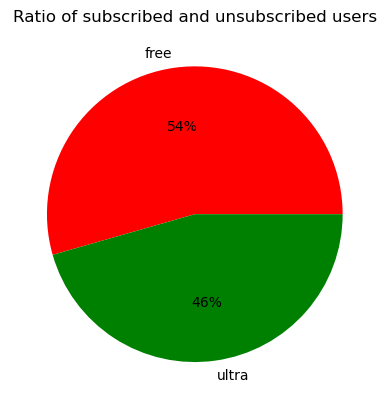

In [15]:
subscription_type_count.plot(
    kind="pie",
    title="Ratio of subscribed and unsubscribed users",
    autopct="%.0f%%",
    ylabel="",
    colors=["red", "green"]
)

# Displaying a graph
plt.show()

### Study of Ages

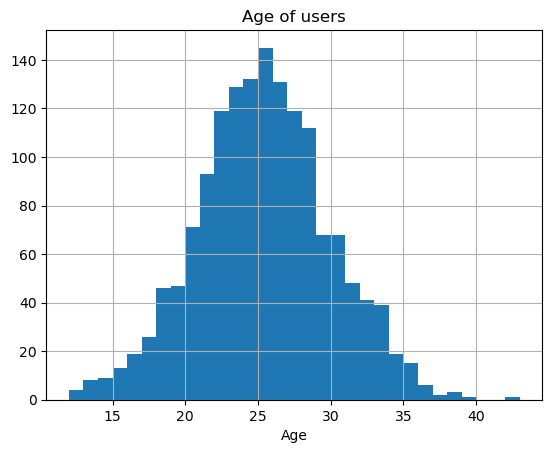

In [16]:
n_bins = df_users_go['age'].max() - df_users_go['age'].min()
df_users_go['age'].hist(bins = n_bins)
plt.title('Age of users')
plt.xlabel('Age')
plt.show()

In [17]:
users_under_18_ratio = round(len(df_users_go[df_users_go["age"] < 18]) / len(df_users_go) * 100)
print(f'The share of underage scooter users is {users_under_18_ratio}%.')

The share of underage scooter users is 5%.


### Trip duration characteristics

In [18]:
duration_mean = round(df_rides_go["duration"].mean())
duration_std = round(df_rides_go["duration"].std())

duration_pct25 = round(df_rides_go["duration"].quantile(0.25))
duration_pct75 = round(df_rides_go["duration"].quantile(0.75))

print(f'The average trip duration is {duration_mean} minutes with a standard deviation of {duration_std}. The majority of trips take between {duration_pct25} and {duration_pct75} minutes.')

The average trip duration is 18 minutes with a standard deviation of 6. The majority of trips take between 14 and 22 minutes.


## Объединение данных

Let's create a single dataframe with information about users and trips

In [23]:
# Merge dataframes df_users_go and df_rides_go by column user_id
df = df_users_go.merge(df_rides_go, on="user_id", how="left")

# We rearrange the columns in the desired order
df = df[["user_id", "distance", "duration", "date", "month", "name", "age", "city", "subscription_type"]]

In [24]:
# Let's add information about the subscription type
df = df.merge(df_subscriptions_go, on="subscription_type", how="left")

In [25]:
display(df.head(5))

n_rows, n_cols = df.shape
print(f'The resulting dataframe has {n_rows} rows and {n_cols} columns.')

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,26,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,16,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,19,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


The resulting dataframe has 18068 rows and 12 columns.


Let's create two independent dataframes based on `df`: the first one is only for users with the 'df_ultra' subscription and the second one is only for users without subscription.

In [27]:
df_ultra = df[df['subscription_type'] == 'ultra']

df_free = df[df['subscription_type'] == 'free']

We explore the duration of trips for users with and without a subscription

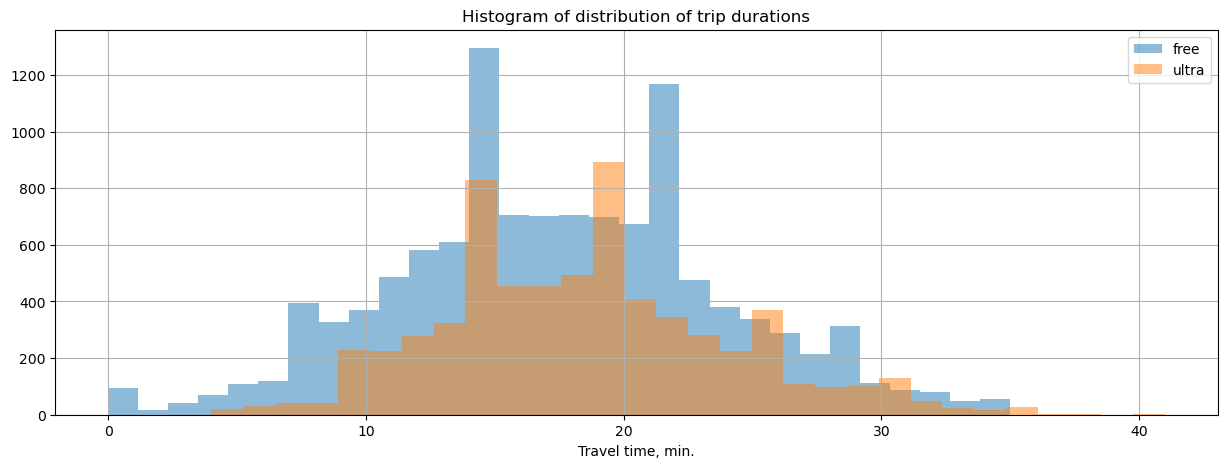

The average trip duration for users without a subscription is 17 min, and for users with a subscription is 19 min


In [28]:
# Trip duration histogram for users with and without subscription
plt.figure(figsize=(15, 5))
# Build a histogram for users without a subscription
df_free['duration'].hist(bins=30, label='free', alpha=0.5)

# Build a histogram for users with subscription
df_ultra['duration'].hist(bins=30, label='ultra', alpha=0.5)

plt.xlabel('Travel time, min.')
plt.title('Histogram of distribution of trip durations')

plt.legend()

plt.show()

# Calculate average trip duration for users without a subscription
mean_duration_free = round(df_free['duration'].mean())

# Calculate average trip duration for users with subscription
mean_duration_ultra = round(df_ultra['duration'].mean())
print(f'The average trip duration for users without a subscription is {mean_duration_free} min, and for users with a subscription is {mean_duration_ultra} min')

## Calculating revenue

Data on the number and duration of trips is combined with prices and tariffs, which means that now there is everything necessary to calculate an important indicator for business - revenue.

In [29]:
df_gp = df.groupby(['user_id', 'name', 'subscription_type', 'month'], as_index=False)

In [30]:
df_agg = df_gp.agg(
    total_distance=('distance', 'sum'),
    total_duration= ('duration', 'sum'),
    rides_count= ('duration', 'count'),
    subscription_type= ('subscription_type', 'first'),
    minute_price= ('minute_price', 'first'),
    start_ride_price= ('start_ride_price', 'first'),
    subscription_fee= ('subscription_fee', 'first'),
)

In [31]:
# Let's create a function calculate_monthly_revenue(row) to calculate monthly revenue
def calculate_monthly_revenue(row):
    return (row['start_ride_price'] * row['rides_count'] +
            row['minute_price'] * row['total_duration'] +
            row['subscription_fee'])

Let's create a new column with monthly revenue per user 'monthly_revenue'. To do this, apply the calculate_monthly_revenue(row) function to each row of the aggregated dataframe `df_agg`.

In [32]:
df_agg['monthly_revenue'] = df_agg.apply(calculate_monthly_revenue, axis=1)

In [33]:
# Find the user_id with the maximum total revenue
top_user_id = df_agg.groupby('user_id')['monthly_revenue'].sum().idxmax()

# Filter data by this user
top_user_data = df_agg[df_agg['user_id'] == top_user_id][['user_id', 'name', 'month', 'rides_count', 'monthly_revenue']]

print(top_user_data)

      user_id       name  month  rides_count  monthly_revenue
8877     1236  Александр      1            2              228
8878     1236  Александр      2            3              614
8879     1236  Александр      3            5              762
8880     1236  Александр      4            1              202
8881     1236  Александр      5            3              574
8882     1236  Александр      6            1              282
8883     1236  Александр      7            1              290
8884     1236  Александр      8            2              452
8885     1236  Александр      9            1              122
8886     1236  Александр     10            3              430
8887     1236  Александр     11            3              494
8888     1236  Александр     12            2              476


---
## Hypothesis testing

Let's write an auxiliary function `print_stattest_results(p_value, alpha)` that will interpret the results of a statistical test based on the p-value and the specified significance level (α-level). The function will decide whether to accept the alternative hypothesis or keep the null hypothesis.

The function has two parameters:
- `p_value` (type `float`) — the p-value obtained as a result of performing the statistical test.
- `alpha` (type `float`, optional, by default `alpha = 0.05`) — the significance level of the statistical test, which is used as a threshold for deciding to reject the null hypothesis.

If the alternative hypothesis is accepted, the following message is printed:
`'The obtained value p_value=<Entered value p_value> is less than the critical level alpha=0.05. Accept the alternative hypothesis.'`

If the null hypothesis cannot be rejected, the following message is displayed: `'The obtained value p_value=<The entered value p_value> is greater than the critical level alpha=0.05. The null hypothesis cannot be rejected.'`

We call the function for `p_value = 0.0001` and `p_value = 0.1`.

In [41]:
def print_stattest_results(p_value:float, alpha:float = 0.05):
    if p_value < alpha:
        print(f"The obtained value p_value={p_value} is less than the critical level alpha={alpha}. We accept the alternative hypothesis.")
    else:
        print(f"The obtained value p_value={p_value} is greater than the critical level alpha={alpha}. The null hypothesis cannot be rejected.") 
print_stattest_results(p_value=0.0001)
print_stattest_results(p_value=0.1)

The obtained value p_value=0.0001 is less than the critical level alpha=0.05. We accept the alternative hypothesis.
The obtained value p_value=0.1 is greater than the critical level alpha=0.05. The null hypothesis cannot be rejected.


### Duration for users with and without a subscription

It is important to understand whether users with a subscription spend more time on trips? Let's formulate the null and alternative hypotheses:
- Null hypothesis (H0): The average trip time for users with and without a subscription is the same.
- Alternative hypothesis (H1): The average trip time for users with a subscription is longer than for users without a subscription.

In [44]:
ultra_duration = df_ultra['duration']
free_duration = df_free['duration']

results = st.ttest_ind(ultra_duration, free_duration, alternative='greater' )
p_value = results.pvalue
print_stattest_results(p_value)
ultra_mean_duration = round(ultra_duration.mean(), 2)
free_mean_duration = round(free_duration.mean(), 2)

print(f'Average trip duration of Ultra subscribers {ultra_mean_duration}')
print(f'Average trip duration of Free subscribers {free_mean_duration}')

The obtained value p_value=3.1600689435611813e-35 is less than the critical level alpha=0.05. We accept the alternative hypothesis.
Average trip duration of Ultra subscribers 18.55
Average trip duration of Free subscribers 17.39


### Trip duration: greater or less than the critical value

Let's analyze another important product hypothesis. The distance of one trip of 3130 meters is optimal in terms of scooter wear. Can we say that the distance that users with a subscription travel in one trip is less than 3130 meters?

Let's formulate the null and alternative hypotheses:

- Null hypothesis (H0): The average trip distance for users with a subscription is 3130 m.

- Alternative hypothesis (H1): The average trip distance for users with a subscription is greater than 3130 m.

In [42]:
null_hypothesis = 3130
ultra_distance = df_ultra['distance']

results = st.ttest_1samp(ultra_distance, null_hypothesis, alternative='greater')
p_value = results.pvalue
print_stattest_results(p_value)

The obtained value p_value=0.9195368847849785 is greater than the critical level alpha=0.05. The null hypothesis cannot be rejected.


### Revenue from users with and without a subscription

Test the hypothesis that revenue from users with a subscription is higher than revenue from users without a subscription.

Let's formulate the null and alternative hypotheses:

- Null hypothesis (H0): The average monthly revenue of users with and without a subscription is the same.
- Alternative hypothesis (H1): The average monthly revenue of users with a subscription is higher than that of users without a subscription.

In [45]:
revenue_ultra = df_agg[df_agg['subscription_type'] == 'ultra']['monthly_revenue']
revenue_free = df_agg[df_agg['subscription_type'] == 'free']['monthly_revenue']

results = st.ttest_ind(revenue_ultra, revenue_free, alternative='greater')
p_value = results.pvalue
print_stattest_results(p_value)

mean_revenue_ultra = round(revenue_ultra.mean())
mean_revenue_free = round(revenue_free.mean())

print(f'Average revenue of Ultra subscribers {mean_revenue_ultra} RUB')
print(f'Average revenue of subscribers Free {mean_revenue_free} RUB')

The obtained value p_value=1.7274069878387966e-37 is less than the critical level alpha=0.05. We accept the alternative hypothesis.
Average revenue of Ultra subscribers 359 RUB
Average revenue of subscribers Free 322 RUB


## Distributions

The company came up with the idea of ​​offering an additional discount to subscribers who make long trips lasting more than 30 minutes. Let's estimate the share of such trips.

In [46]:
# Calculate the average value
mu = df_ultra['duration'].mean()

# Calculate the standard deviation
sigma = df_ultra['duration'].std()

# Set the target time
target_time = 30

# Conclusion
print(f'Average trip duration {round(mu, 1)}, standard deviation {round(sigma)}.')

Average trip duration 18.5, standard deviation 6.


### Calculating the value of the distribution function at a point (CDF)

In [47]:
# Calculate the probability that a random variable will be less than or equal to the specified value
duration_norm_dist  = st.norm(loc=mu, scale=sigma)
prob = round(1 - duration_norm_dist.cdf(target_time), 2)

print(f'Probability of travel more than 30 minutes {prob}')

Probability of travel more than 30 minutes 0.02


### Probability for interval (CDF)

The percentage of users for whom the discount will be shown is not large enough and is unlikely to help increase customer loyalty. Let's also check what percentage of users make trips in the interval from 20 to 30 minutes. Perhaps it is for them that the promotion should be held.

In [48]:
# Define the interval boundaries
low = 20
high = 30

duration_norm_dist = st.norm(loc=mu, scale=sigma)

# Calculate the probability of falling into the interval
prob_interval = round(duration_norm_dist.cdf(high) - duration_norm_dist.cdf(low), 3)

# Print the result
print(f'The probability that a user will take a trip lasting between {low} and {high} minutes is: {prob_interval}')

The probability that a user will take a trip lasting between 20 and 30 minutes is: 0.377


### Determining the critical travel distance (PPF)
Long trips can have a negative impact on the service life of a scooter. In this regard, it was decided to establish a critical distance, exceeding which will be accompanied by an additional fee. To do this, it is necessary to determine the distance that is exceeded only in 10% of trips (90th percentile).

In [49]:
# Calculate the average value
mu = df['distance'].mean()

# Calculate the standard deviation
sigma = df['distance'].std()

# Probability for which we want to find the value (90% of cases)
target_prob = 0.90

# Create a normal distribution object
distance_norm = st.norm(loc=mu, scale=sigma)

# Calculate the critical distance for a given percentile of trips
critical_distance = distance_norm.ppf(target_prob)

print(f'{100 * target_prob} % of trips have a distance below the critical value {critical_distance:.2f} M.')

90.0 % of trips have a distance below the critical value 4501.94 M.
